# Explore DESI SV3 cutsky

In order to generate the files in _tests directory, you have to run:

`salloc -N 4 -C haswell -t 00:30:00 --qos interactive -L SCRATCH,project`

`srun -n 256 python from_box_to_desi_sv3_cutsky.py`

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from mockfactory import Catalog, RedshiftDensityInterpolator

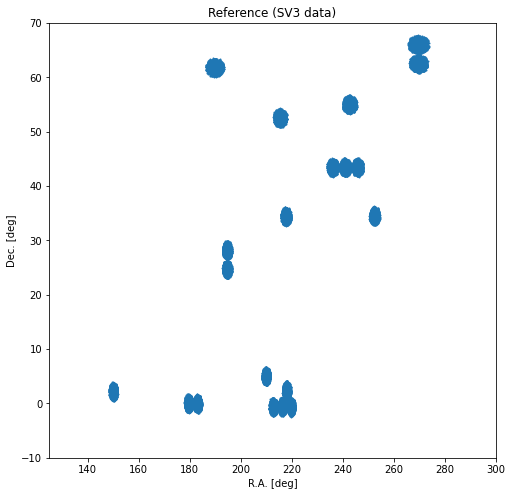

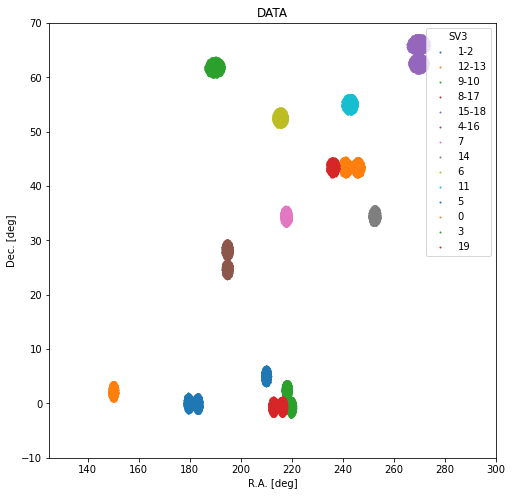

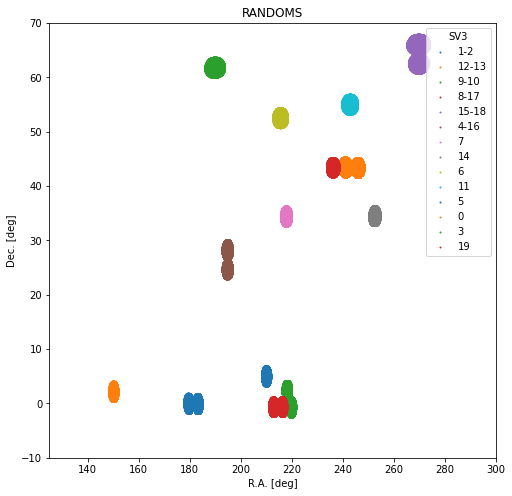

In [2]:
outdir = '_tests'

def catalog_fn(name, rosettes, imock=0):
    # name is 'data', 'randoms'; rosettes is list of rosette numbers
    return os.path.join(outdir, '{}_rosettes-{}_{:d}.fits'.format(name, '-'.join([str(rosette) for rosette in rosettes]), imock))

ref_fn = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/fuji/LSScats/EDAbeta/ELG_{}_clustering.dat.fits'
all_rosettes = [(1, 2), (12, 13), (9, 10), (8, 17), (15, 18), (4, 16), (7,), (14,), (6,), (11,), (5,), (0,), (3,), (19,)]
regions = ['N', 'S']

# Sky coverage
xlim = (125, 300)
ylim = (-10, 70)
figsize = (8, 8)

plt.figure(figsize=figsize)
catalog = Catalog.read([ref_fn.format(region) for region in regions])
plt.scatter(catalog['RA'][::10], catalog['DEC'][::10], s=1)
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec. [deg]')
plt.xlim(xlim)
plt.ylim(ylim)
plt.title('Reference (SV3 data)')
plt.show()


for name in ['data', 'randoms']:
    plt.figure(figsize=figsize)
    for rosettes in all_rosettes:
        catalog = Catalog.read(catalog_fn(name, rosettes))
        plt.scatter(catalog['RA'][::10], catalog['DEC'][::10], s=1, label='-'.join([str(rosette) for rosette in rosettes]))
    plt.xlabel('R.A. [deg]')
    plt.ylabel('Dec. [deg]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(title='SV3', loc='upper right')
    plt.title(name.upper())
    plt.show()

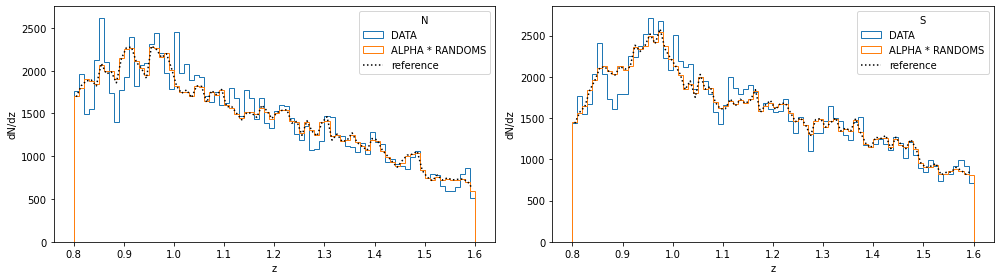

In [3]:
plt.figure(figsize=(14, 4))

regions = ['N', 'S']

zlim = (0.8, 1.6)
bins = np.arange(zlim[0], zlim[1] + 1e-3, step=0.01)
data = Catalog.read([catalog_fn('data', rosettes) for rosettes in all_rosettes])
randoms = Catalog.read([catalog_fn('randoms', rosettes) for rosettes in all_rosettes])

def mask_region(catalog, region):
    mask = catalog['DEC'] > 32.375
    if region == 'S': mask = ~mask
    return mask

for i, region in enumerate(regions):
    plt.subplot(121 + i)
    ref = Catalog.read(ref_fn.format(region))
    nz = RedshiftDensityInterpolator(ref['Z'], bins=bins, fsky=None)
    mask_data, mask_randoms = mask_region(data, region), mask_region(randoms, region)
    #print(mask_data.sum() / np.sum((ref['Z'] > zlim[0]) & (ref['Z'] < zlim[1])), 1./mask_data.sum()**0.5)
    plt.hist(data['Z'][mask_data], density=False, histtype='step', bins=bins, label='DATA')
    nrandoms = mask_randoms.sum()
    plt.hist(randoms['Z'][mask_randoms], weights=np.full(nrandoms, mask_data.sum() / nrandoms), density=False, histtype='step', bins=bins, label='ALPHA * RANDOMS')
    plt.plot(nz.z, nz(nz.z), c='k', ls=':', label='reference')
    plt.legend(title=region)
    plt.xlabel('z')
    plt.ylabel('dN/dz')
plt.tight_layout()
plt.show()